In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import json
import pandas as pd

In [3]:
TOKENS = 'tokens'
PREDS = 'preds'

In [4]:
def load_output(path):
  with open(path, 'r') as f:
    loaded_json = json.load(f)
    df = pd.DataFrame.from_dict(loaded_json, orient='index', columns=[PREDS, TOKENS])
  
  print('Finish loading output.')
  return df

In [5]:
ROOT = '/content/drive/My Drive/nlp-data/'
COVID_TOKENS = ROOT + 'covid_tokens.json'

tokens_set = load_output(COVID_TOKENS)

Finish loading output.


In [6]:
rumour_tokens = {}
non_rumour_tokens = {}

for index, row in tokens_set.iterrows():
  # print(row['tokens'])
  flatlist = [token for tokens in row['tokens'] for token in tokens]
  # print(flatlist)
  # break
  if row['preds'] == 'rumour':
    rumour_tokens[index] = [flatlist]
  else:
    non_rumour_tokens[index] = [flatlist]

rumour_df = pd.DataFrame.from_dict(rumour_tokens, orient='index',columns=['tokens'])
non_rumour_df = pd.DataFrame.from_dict(non_rumour_tokens, orient='index',columns=['tokens'])
rumour_dict = gensim.corpora.Dictionary(rumour_df['tokens'])
non_rumour_dict = gensim.corpora.Dictionary(non_rumour_df['tokens'])

rumour_bow = [rumour_dict.doc2bow(tweet) for tweet in rumour_df['tokens']]
non_rumour_bow = [rumour_dict.doc2bow(tweet) for tweet in non_rumour_df['tokens']]

# print(non_rumour_bow)

In [7]:
rumour_coherences = {}
non_rumour_coherences = {}
rumour_topics = {}
non_rumour_topics = {}

# k_lst = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80]
k_lst = [60]
for k in k_lst:
  rumour_lda = gensim.models.LdaMulticore(rumour_bow, 
                                        num_topics=k,
                                        id2word=rumour_dict,
                                        random_state=1,
                                        passes=10,
                                        chunksize=100)

  non_rumour_lda = gensim.models.LdaMulticore(non_rumour_bow, 
                                        num_topics=k,
                                        id2word=rumour_dict,
                                        random_state=1,
                                        passes=10,
                                        chunksize=100)
  print("Finish topic classifiers with k = ", k)

  rumour_coherences[k] = CoherenceModel(model=rumour_lda, texts=rumour_df['tokens'], dictionary=rumour_dict, coherence='c_v').get_coherence()
  non_rumour_coherences[k] = CoherenceModel(model=non_rumour_lda, texts=rumour_df['tokens'], dictionary=rumour_dict, coherence='c_v').get_coherence()
  
  rumour_topics[k] = {'Topic_' + str(i+1): [token for token, score in rumour_lda.show_topic(i, topn=15)] for i in range(0, rumour_lda.num_topics)}
  non_rumour_topics[k] = {'Topic_' + str(i+1): [token for token, score in non_rumour_lda.show_topic(i, topn=15)] for i in range(0, non_rumour_lda.num_topics)}

Finish topic classifiers with k =  60


In [8]:
print(rumour_coherences)

{60: 0.43099248670031065}


In [9]:
print(non_rumour_coherences)

{60: 0.47321066801248374}


Text(0, 0.5, 'Coherence')

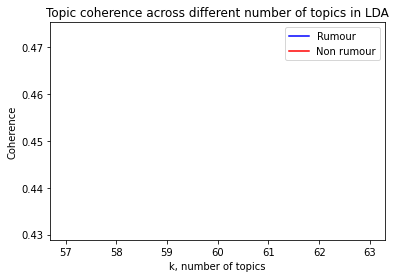

In [10]:
import matplotlib.pylab as plt

rumours = sorted(rumour_coherences.items()) # sorted by key, return a list of tuples
non_rumours = sorted(non_rumour_coherences.items())

x_r, y_r = zip(*rumours) # unpack a list of pairs into two tuples
x_nr, y_nr = zip(*non_rumours) # unpack a list of pairs into two tuples

fig, ax = plt.subplots()
ax.plot(x_r, y_r, 'b', label='Rumour')
ax.plot(x_nr, y_nr, 'r', label='Non rumour')
ax.legend()
ax.set_title('Topic coherence across different number of topics in LDA')
ax.set_xlabel('k, number of topics')
ax.set_ylabel('Coherence')

In [11]:
topic_num = 60

print(rumour_topics[topic_num])
print(non_rumour_topics[topic_num])

{'Topic_1': ['china', 'world', 'chinese', 'outbreak', 'virus', 'theory', 'country', 'madagascar', 'contain', 'wuhanvirus', 'ccp', 'liberal', 'african', 'create', 'wuhan'], 'Topic_2': ['breaking', 'reporter', 'announce', 'captain', 'owner', 'expect', 'coronaviru', 'transmit', 'ohio', 'covid__', 'sound', 'sahara', 'birthday', 'novel', 'two'], 'Topic_3': ['tulsa', 'staff', 'release', 'meet', 'whether', 'victoria', 'wonder', 'maga', 'relief', 'business', 'member', 'risk', 'democratic', 'community', 'policy'], 'Topic_4': ['cummings', 'rule', 'mile', 'hbe', 'travel', 'dominic', 'say', 'children', 'police', 'look', 'matt', 'journey', 'stop', 'parents', 'seems'], 'Topic_5': ['fraud', 'brazil', 'country', 'million', 'vaccine', 'population', 'fund', 'break', 'spain', 'raise', 'usa', 'world', 'herd', 'worth', 'parliament'], 'Topic_6': ['death', 'people', 'number', 'day', 'cases', 'die', 'report', 'state', 'health', 'confirm', 'today', 'daily', 'record', 'caes', 'deaths'], 'Topic_7': ['city', 'don

WordCloud template, not used

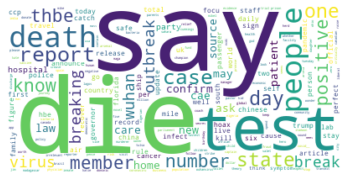

In [12]:
rumour_lst = []
for k, v in rumour_topics[topic_num].items():
  temp = ''
  for word in v:
    temp += word + ' '
  rumour_lst.append(temp)

rumour_keywords = ''
for words in rumour_lst:
  rumour_keywords += words + ' '



from wordcloud import WordCloud
import matplotlib.pyplot as plt
rumour_wordcloud = WordCloud(background_color="white").generate(rumour_keywords)

plt.imshow(rumour_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

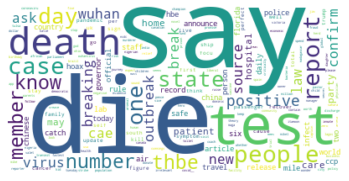

In [13]:
non_rumour_lst = []
for k, v in non_rumour_topics[topic_num].items():
  temp = ''
  for word in v:
    temp += word + ' '
  non_rumour_lst.append(temp)

non_rumour_keywords = ''
for words in rumour_lst:
  non_rumour_keywords += words + ' '

non_rumour_wordcloud = WordCloud(background_color="white").generate(non_rumour_keywords)

plt.imshow(non_rumour_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()